In [2]:
%cd /home/q123/Desktop/explo

import torch 
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.gibo.optim import GIBOptimizer
from src.optim import BOptimizer
from src.config import get_configs

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

/home/q123/Desktop/explo


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.tester import Tester 

#env_name = "Swimmer-v2"
env_name = "CartPole-v1"
kernel_name = "linearstate"
kernel_name2 = "rbf"
delta = 1e-2
n_train =50
n_test = 100
n_episodes = 5 ### number of runs for test episodes / for train = 1

In [4]:
env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name)
additional_layers=[4]
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config,additional_layers)
tester = Tester(model,objective_env,
                 local_opt ="/home/q123/Desktop/explo/local_optima/CartPole-v1_[4, 4, 1]",
                 use_opt_states = True,
                 delta =delta,
                 n_train=n_train,n_test=n_test,n_episodes=n_episodes)

#### generate data for all experiments
train_data,test_data,opt_states = tester.generate_data()

MathLog.src.helpers : WARNING : MLP dimensions : [4, 4, 1]
Using ard_num_dims = 25
local_y 0.9999942183494568 local_opt tensor([-0.1238,  0.0230, -0.1873, -0.4381, -0.0541,  0.0396,  0.1156,  0.2574,
        -0.0377, -0.0358])
 intial local opt reward : 0.9999942183494568
Generating data
Done generating data


##############################
covar_lengthscale max 0.0019960079807788134 / min 0.0019960079807788134
##############################
last parameters tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
##############################
covar_lengthscale max 0.001392526552081108 / min -0.0032981291878968477
##############################
last parameters tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


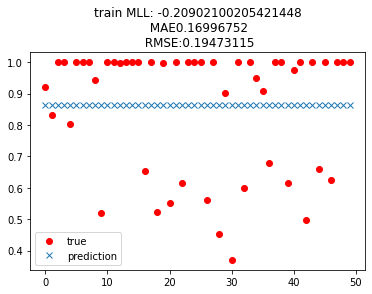

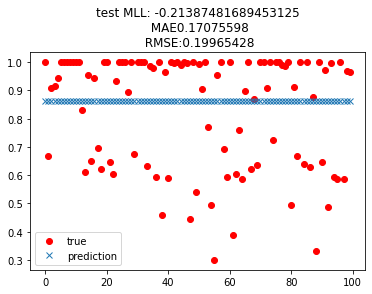

In [5]:
train_data,train_pred,test_data,test_pred,opt_data = tester.run(train_data,test_data,opt_states)

MathLog.src.helpers : WARNING : MLP dimensions : [4, 4, 1]
Using ard_num_dims = 25
local_y 0.9999942183494568 local_opt tensor([-0.1238,  0.0230, -0.1873, -0.4381, -0.0541,  0.0396,  0.1156,  0.2574,
        -0.0377, -0.0358])
 intial local opt reward : 0.9999942183494568
##############################
covar_lengthscale max 0.5 / min 0.5                      covar_outputscale 1.9999998807907104                     noise 0.30000001192092896
##############################
last parameters tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
##############################
covar_lengthscale max 0.333386093378067 / min 0.33265241980552673                      covar_outputscale 0.010012351907789707                     noise 0.20000000298023224
##############################
last parameters tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


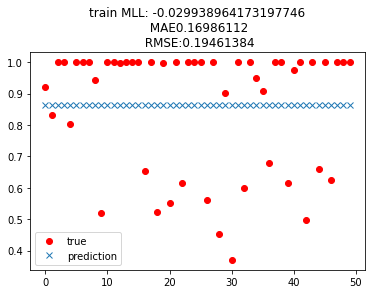

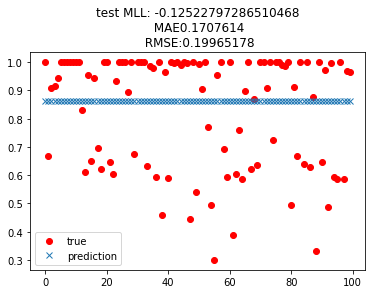

In [6]:
env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name2)
additional_layers=[4]
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config,additional_layers)
tester = Tester(model,objective_env,
                 local_opt ="/home/q123/Desktop/explo/local_optima/CartPole-v1_[4, 4, 1]",
                 use_opt_states = True,
                 delta =delta,
                 n_train=n_train,n_test=n_test,n_episodes=n_episodes)

train_data,train_pred,test_data,test_pred,opt_data = tester.run(train_data,test_data,opt_states)

In [12]:
from sklearn.linear_model import ARDRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


train_x,train_y,train_s = train_data
test_x,test_y,test_s = test_data
local_opt,opt_states = opt_data

Phi_train = tester.model.mlp(train_x,opt_states).flatten(start_dim=1)
Phi_test = tester.model.mlp(test_x,opt_states).flatten(start_dim=1)
Y_train,Y_test = train_y,test_y

ard = make_pipeline(StandardScaler(),
                    ARDRegression(compute_score=True, n_iter=20))

ard.fit(Phi_train, Y_train)

Y_train_pred = ard.predict(Phi_train)
Y_test_pred = ard.predict(Phi_test)

def plot(x,best_x,y,y_hat):
    
    print(x.shape,best_x.shape)
    dist = torch.linalg.norm(x-best_x,dim=1)
    idx = torch.argsort(dist)
    y = y[idx]
    y_hat = y_hat[idx]
    x_plot = range(len(y))
    plt.scatter(x_plot,y,label="true",color="red")
    plt.errorbar(x_plot,y_hat,label="prediction",fmt="x")
    plt.title("MAE:"+str(mae(y,y_hat)) +"/ RMSE :"+str(mse(y,y_hat,squared=False)))


torch.Size([50, 25]) torch.Size([25])


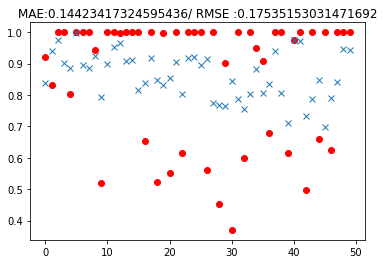

In [13]:
plot(train_x,local_opt.squeeze(),Y_train,Y_train_pred)

torch.Size([100, 25]) torch.Size([25])


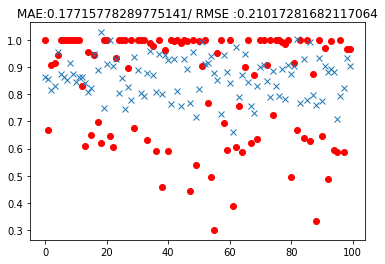

In [14]:
plot(test_x,local_opt.squeeze(),Y_test,Y_test_pred)